# Objective

The objective of this project is to design an end-to-end, data-driven lead prioritization framework that identifies free portals most likely to convert into paying customers within a 30-day horizon.

Beyond predicting conversion probability, the system aligns behavioral signals with targeted outreach strategies to enable revenue teams to engage the right prospects, at the right time, with the right message.

This initiative transforms raw product usage data into a scalable revenue acceleration engine.

The solution integrates four complementary layers:

**1. ICP Qualification (Who should we sell to?)**

Firmographic signals (industry, company size, digital presence) are assessed to determine structural alignment with our Ideal Customer Profile. This ensures that outreach efforts are focused on accounts with long-term revenue potential.

**2. Behavioral Intent Modeling (Are they ready?)**

Using 30-day product usage signals, I quantified engagement depth and collaboration patterns to estimate short-term conversion likelihood.

**3. Momentum Detection (Why now?)**

Recency and usage acceleration signals help identify accounts exhibiting heightened activity, indicating near-term buying intent.

**4. GenAI-Based Segmentation (How should we approach them?)**

We leverage generative AI to translate behavioral signals into structured playbooks and personalized outreach strategies, ensuring messaging aligns with how prospects are already using the platform.

Together, these layers move the system beyond static lead scoring into dynamic, behavior-driven revenue orchestration.

# Key Assumptions

The non_customers.csv dataset contains active free-tier portals that have not yet converted. While there is no explicit “free vs. paid” flag, absence from the customer dataset is treated as non-paying status.


# End-to-end Process flow:

**Step 1: Behavioral Scoring (XGBoost)**

We train an XGBoost classifier to estimate 30-day conversion probability based on rolling usage aggregates, firmographic attributes, and recency metrics.

Output: Calibrated conversion probability score (P_CONVERT_30D)

**Step 2: GenAI powered Segmentation**

For top-ranked accounts, we apply LLM-based segmentation to assign behavior patterns, lifecycle stages, and targeted playbook focus.

Output: Structured behavioral classification + tailored outreach messaging

**Step 3: Weekly Ranked Output**

Each Sunday, the pipeline produces a prioritized, sales-ready prospect list containing:

- Conversion probability

- Behavioral segment

- Playbook focus

- Recommended messaging

This enables immediate activation by revenue teams.

# Technology Stack

**1. Predictive Modeling**

- XGBoost Classifier for nonlinear interaction modeling

- Optuna for hyperparameter optimization

- Logistic Regression as a baseline benchmark model

**2. Evaluation Framework**

- Primary metric: ROC-AUC

- Logistic regression used as a baseline comparator to measure incremental lift and nonlinear modeling advantage

**3. Generative AI Layer**

- LLM integration for behavioral segmentation and structured outreach generation

- Schema-constrained output to ensure production consistency

# Import Packages

In [1]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import helper functions using the class object
from utilities.helper_functions_for_forecasting import helper_functions_obj

import xgboost as xgb

import json
import time
from openai import OpenAI

# Data Gathering

#### Data Sources:

customers.csv → Paying customers

noncustomers.csv → Free portals

usage_actions.csv → CRM usage signals



#### Business Interpretation of Data:

    Firmographics→	ICP fit

    Usage actions→ Engagement depth

    Users count→	Organizational adoption

    Recency→	Buying intent timing

In [ ]:
# -------------------------
# CONFIG
# -------------------------
CUSTOMERS_CSV = "data/customers.csv"
NONCUSTOMERS_CSV = "data/noncustomers.csv"
USAGE_CSV = "data/usage_actions.csv"

USAGE_ACTION_COLS = [
    "ACTIONS_CRM_CONTACTS",
    "ACTIONS_CRM_COMPANIES",
    "ACTIONS_CRM_DEALS",
    "ACTIONS_EMAIL",
]
USAGE_USER_COLS = [
    "USERS_CRM_CONTACTS",
    "USERS_CRM_COMPANIES",
    "USERS_CRM_DEALS",
    "USERS_EMAIL",
]

FIRMOGRAPHIC_COLS = ["ALEXA_RANK", "EMPLOYEE_RANGE", "INDUSTRY"]

LOOKBACK_WINDOWS_DAYS = [7, 14, 30]  # typical
HORIZON_DAYS = 30                    # "convert within next 30 days"
SCORING_WEEKDAY = "SUN"              # Sundays


# -------------------------
# LOAD DATA
# -------------------------
customers = pd.read_csv(CUSTOMERS_CSV)
# Rename 'ID' column to 'id' for consistency with noncustomers
customers = customers.rename(columns={'ID': 'id'})
noncustomers = pd.read_csv(NONCUSTOMERS_CSV)
usage = pd.read_csv(USAGE_CSV)

# Data Cleaning, Processing and Transformation

This stage ensures reliable signals:

- Unified company ID

- Log-transform skewed features (e.g., Alexa rank)

- Created 30-day rolling aggregates

- Derived DAYS_SINCE_LAST_ACTIVITY

- Handled missing values


#### Insight:

We convert raw activity logs into structured behavioral signals aligned to a 30-day prediction horizon.

In [4]:
# =============================================================================
# DATA CLEANING, PROCESSING AND TRANSFORMATION
# =============================================================================

# --- 1. Column naming and validation ---
if "ID" in usage.columns:
    usage = usage.rename(columns={"ID": "id"})

for col in ["id", "CLOSEDATE", "MRR", *FIRMOGRAPHIC_COLS]:
    if col not in customers.columns:
        raise ValueError(f"customers.csv missing required column: {col}")
for col in ["id", *FIRMOGRAPHIC_COLS]:
    if col not in noncustomers.columns:
        raise ValueError(f"noncustomers.csv missing required column: {col}")
for col in ["id", "WHEN_TIMESTAMP", *USAGE_ACTION_COLS, *USAGE_USER_COLS]:
    if col not in usage.columns:
        raise ValueError(f"usage_actions.csv missing required column: {col}")

# --- 2. Parse dates ---
customers["CLOSEDATE"] = pd.to_datetime(customers["CLOSEDATE"], errors="coerce")
usage["WHEN_TIMESTAMP"] = pd.to_datetime(usage["WHEN_TIMESTAMP"], errors="coerce")

# --- 3. Build firmographic table (customers + noncustomers; customer wins on duplicate id) ---
firm = pd.concat(
    [
        customers[["id", *FIRMOGRAPHIC_COLS]].assign(_is_customer=1),
        noncustomers[["id", *FIRMOGRAPHIC_COLS]].assign(_is_customer=0),
    ],
    ignore_index=True,
)
firm = firm.sort_values("_is_customer", ascending=False).drop_duplicates("id").drop(columns=["_is_customer"])



close_map = customers.set_index("id")["CLOSEDATE"]

# --- 4. Daily usage aggregation (per company, per day) ---
usage_daily = usage.copy()
usage_daily["DATE"] = usage_daily["WHEN_TIMESTAMP"].dt.normalize()
agg_cols = USAGE_ACTION_COLS + USAGE_USER_COLS
usage_daily = (
    usage_daily.groupby(["id", "DATE"], as_index=False)[agg_cols]
    .sum()
    .sort_values(["id", "DATE"])
)

# Complete daily index per company so rolling windows have no gaps.
usage_daily_full = (
    usage_daily.groupby("id", group_keys=False)
    .apply(lambda df: helper_functions_obj.complete_daily_index(df, agg_cols))
    .sort_values(["id", "DATE"])
)

# --- 5. Weekly Sunday snapshots and rolling usage features ---
global_start = usage_daily_full["DATE"].min()
global_end = usage_daily_full["DATE"].max()
sundays = helper_functions_obj.make_sunday_index(global_start, global_end)
usage_daily_full = usage_daily_full.set_index("DATE")


# new feature 1 : Numeric midpoint of EMPLOYEE_RANGE for modeling (e.g. "11 to 25" -> 18).
firm["EMPLOYEE_RANGE_MID"] = firm["EMPLOYEE_RANGE"].apply(helper_functions_obj.parse_employee_range_to_midpoint)

# new feature 2 : log(1 + ALEXA_RANK) for scale and model stability; handles zeros/missing.
firm["ALEXA_RANK_LOG1P"] = helper_functions_obj.safe_log1p(firm["ALEXA_RANK"])

# new feature 3 : Rolling sums of actions/users over 7, 14, 30 days; one column per (metric, window), e.g. ACTIONS_CRM_DEALS_7D_SUM.
features_list = []
for w in LOOKBACK_WINDOWS_DAYS:
    rolled = (
        usage_daily_full.groupby("id")[agg_cols]
        .rolling(window=w, min_periods=1)
        .sum()
        .reset_index()
    )
    rolled = rolled[rolled["DATE"].isin(sundays)].copy()
    rename = {c: f"{c}_{w}D_SUM" for c in agg_cols}
    rolled = rolled.rename(columns=rename)
    features_list.append(rolled)

snap = features_list[0]
for df in features_list[1:]:
    snap = snap.merge(df, on=["id", "DATE"], how="outer")

# new feature 4 : Days since last activity (any action/user) as of snapshot date; measures recency/engagement.
daily_totals = usage_daily_full.reset_index()
daily_totals["ANY_ACTIVITY"] = (daily_totals[agg_cols].sum(axis=1) > 0).astype(int)
last_active = (
    daily_totals[daily_totals["ANY_ACTIVITY"] == 1]
    .groupby("id")["DATE"]
    .apply(list)
    .to_dict()
)
snap["DAYS_SINCE_LAST_ACTIVITY"] = [
    helper_functions_obj.days_since_last_activity(cid, d, last_active) for cid, d in zip(snap["id"], snap["DATE"])
]

# --- 6. Join firmographics and close date; restrict to pre-close snapshots ---
snap = snap.merge(firm, on="id", how="left")
snap["CLOSEDATE"] = snap["id"].map(close_map)
snap = snap[(snap["CLOSEDATE"].isna()) | (snap["DATE"] < snap["CLOSEDATE"])].copy()

# new feature 5 : Binary target — 1 if company closes within HORIZON_DAYS (30) after snapshot date, else 0.
snap["LABEL_CONVERT_30D"] = 0
mask_pos = (
    snap["CLOSEDATE"].notna()
    & (snap["CLOSEDATE"] > snap["DATE"])
    & (snap["CLOSEDATE"] <= snap["DATE"] + pd.Timedelta(days=HORIZON_DAYS))
)
snap.loc[mask_pos, "LABEL_CONVERT_30D"] = 1

# Exploratory Data Analysis

We explore the modeling snapshot dataset: firmographics, usage features, and the conversion target to inform modeling and feature interpretation.

#### Key findings:

Alexa rank is heavily skewed → mostly SMBs

Recency strongly skewed → many recently active users

Employee midpoint feature required correction

Usage distributions show long-tail behavior


#### Insights:

Conversion likelihood is tied more to engagement and recency than static firmographics.

Recency and deal activity are strong signals of intent.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid", palette="husl", font_scale=1.05)
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    plt.style.use("seaborn-v0_8-whitegrid" if "seaborn-v0_8-whitegrid" in plt.style.available else "default")

# --- 1) Data overview ---
print("=" * 60)
print("SNAPSHOT DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {snap.shape[0]:,} rows × {snap.shape[1]} columns")
print(f"Date range: {snap['DATE'].min().date()} to {snap['DATE'].max().date()}")
print(f"Unique companies (id): {snap['id'].nunique():,}")
print()
print("Target (LABEL_CONVERT_30D):")
print(snap["LABEL_CONVERT_30D"].value_counts().to_string())
print(f"Conversion rate: {snap['LABEL_CONVERT_30D'].mean():.2%}")
print()
print("Missing values (top columns):")
missing = snap.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False).head(10)
print(missing.to_string() if len(missing) else "None")

SNAPSHOT DATASET OVERVIEW
Shape: 41,992 rows × 34 columns
Date range: 2019-01-13 to 2020-07-26
Unique companies (id): 2,018

Target (LABEL_CONVERT_30D):
0    41377
1      615
Conversion rate: 1.46%

Missing values (top columns):
CLOSEDATE                   38368
INDUSTRY                    31233
DAYS_SINCE_LAST_ACTIVITY    14476
EMPLOYEE_RANGE_MID           3552
EMPLOYEE_RANGE               3417
ALEXA_RANK                    310
ALEXA_RANK_LOG1P              310


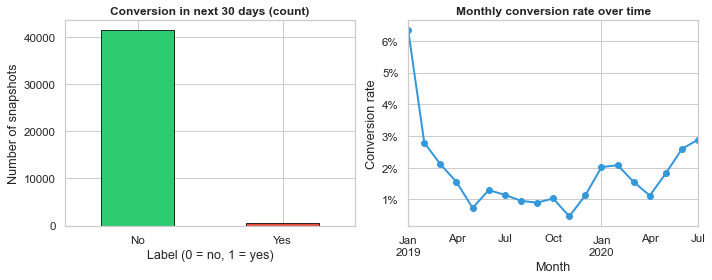

In [6]:
# --- 2) Target distribution ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
snap["LABEL_CONVERT_30D"].value_counts().sort_index().plot(kind="bar", ax=ax, color=["#2ecc71", "#e74c3c"], edgecolor="black", linewidth=0.8)
ax.set_title("Conversion in next 30 days (count)", fontsize=12, fontweight="bold")
ax.set_xlabel("Label (0 = no, 1 = yes)")
ax.set_xticklabels(["No", "Yes"], rotation=0)
ax.set_ylabel("Number of snapshots")

ax = axes[1]
snap.groupby(snap["DATE"].dt.to_period("M"))["LABEL_CONVERT_30D"].mean().plot(ax=ax, marker="o", color="#3498db", linewidth=2, markersize=6)
ax.set_title("Monthly conversion rate over time", fontsize=12, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Conversion rate")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
plt.tight_layout()
plt.show()

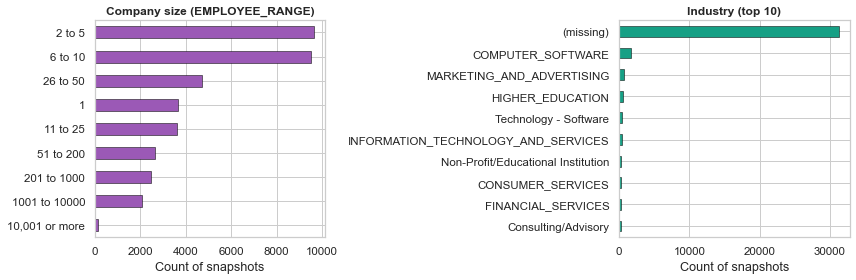

In [7]:
# --- 3) Firmographics: EMPLOYEE_RANGE & INDUSTRY ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Employee range (top 12)
emp_counts = snap["EMPLOYEE_RANGE"].value_counts().head(12)
emp_counts.sort_values(ascending=True).plot(kind="barh", ax=axes[0], color="#9b59b6", edgecolor="black", linewidth=0.5)
axes[0].set_title("Company size (EMPLOYEE_RANGE)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Count of snapshots")

# Industry (top 10)
ind_counts = snap["INDUSTRY"].fillna("(missing)").value_counts().head(10)
ind_counts.sort_values(ascending=True).plot(kind="barh", ax=axes[1], color="#16a085", edgecolor="black", linewidth=0.5)
axes[1].set_title("Industry (top 10)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Count of snapshots")
plt.tight_layout()
plt.show()

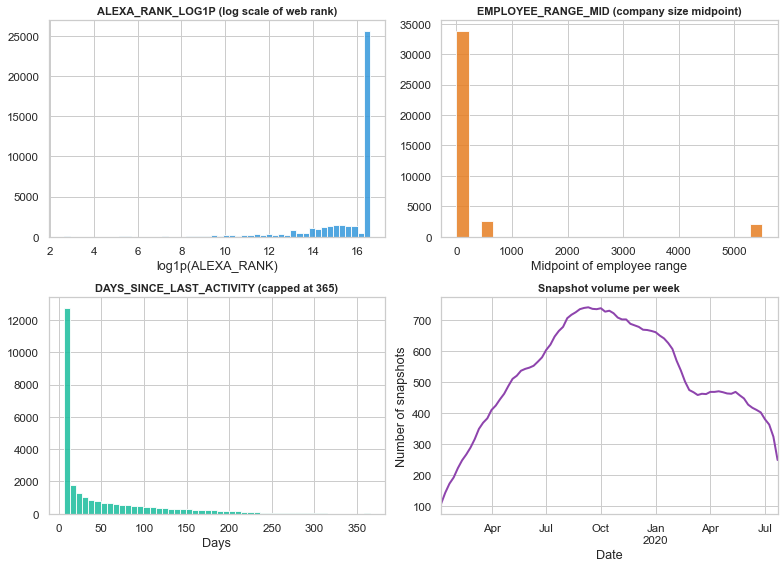

In [8]:
# --- 4) Key numeric features (distributions) ---
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# ALEXA_RANK_LOG1P
ax = axes[0, 0]
snap["ALEXA_RANK_LOG1P"].dropna().hist(ax=ax, bins=50, color="#3498db", edgecolor="white", alpha=0.85)
ax.set_title("ALEXA_RANK_LOG1P (log scale of web rank)", fontsize=11, fontweight="bold")
ax.set_xlabel("log1p(ALEXA_RANK)")

# EMPLOYEE_RANGE_MID
ax = axes[0, 1]
emp_mid = snap["EMPLOYEE_RANGE_MID"].replace([np.inf, -np.inf], np.nan).dropna()
if len(emp_mid) > 0:
    emp_mid.hist(ax=ax, bins=min(25, max(10, len(emp_mid) // 50)), color="#e67e22", edgecolor="white", alpha=0.85)
else:
    ax.text(0.5, 0.5, "No valid EMPLOYEE_RANGE_MID", ha="center", va="center", transform=ax.transAxes)
ax.set_title("EMPLOYEE_RANGE_MID (company size midpoint)", fontsize=11, fontweight="bold")
ax.set_xlabel("Midpoint of employee range")

# DAYS_SINCE_LAST_ACTIVITY
ax = axes[1, 0]
snap["DAYS_SINCE_LAST_ACTIVITY"].replace([np.inf, -np.inf], np.nan).dropna().clip(upper=365).hist(ax=ax, bins=50, color="#1abc9c", edgecolor="white", alpha=0.85)
ax.set_title("DAYS_SINCE_LAST_ACTIVITY (capped at 365)", fontsize=11, fontweight="bold")
ax.set_xlabel("Days")

# Snapshot volume over time (weekly)
ax = axes[1, 1]
snap.groupby(pd.Grouper(key="DATE", freq="W")).size().plot(ax=ax, color="#8e44ad", linewidth=2)
ax.set_title("Snapshot volume per week", fontsize=11, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Number of snapshots")
plt.tight_layout()
plt.show()

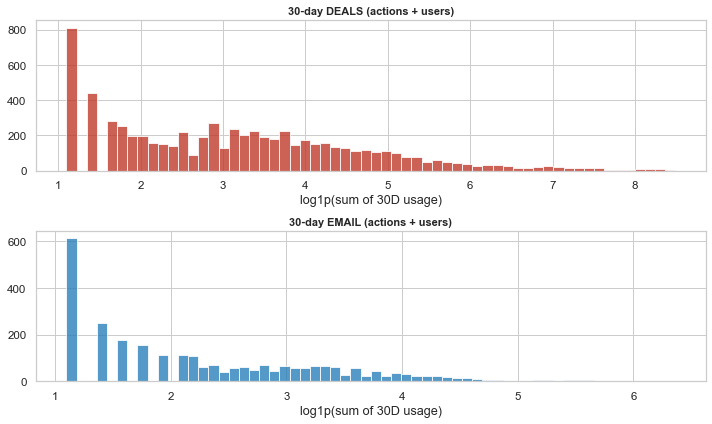

In [9]:
# --- 5) 30-day usage features (actions & users) ---
usage_30_cols = [c for c in snap.columns if c.endswith("_30D_SUM")]
if usage_30_cols:
    # Sum by feature type for a compact view: Deals, Email, Contacts, Companies
    deal_cols = [c for c in usage_30_cols if "DEALS" in c]
    email_cols = [c for c in usage_30_cols if "EMAIL" in c]
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    # Log-scale histograms for 30D dealsw and email (often right-skewed)
    for ax, cols, title, color in [
        (axes[0], deal_cols, "30-day DEALS (actions + users)", "#c0392b"),
        (axes[1], email_cols, "30-day EMAIL (actions + users)", "#2980b9"),
    ]:
        if cols:
            snap[cols].sum(axis=1).replace(0, np.nan).dropna().apply(np.log1p).hist(ax=ax, bins=60, color=color, edgecolor="white", alpha=0.8)
        ax.set_title(title, fontsize=11, fontweight="bold")
        ax.set_xlabel("log1p(sum of 30D usage)")
    plt.tight_layout()
    plt.show()
else:
    print("No *_30D_SUM columns found in snap.")

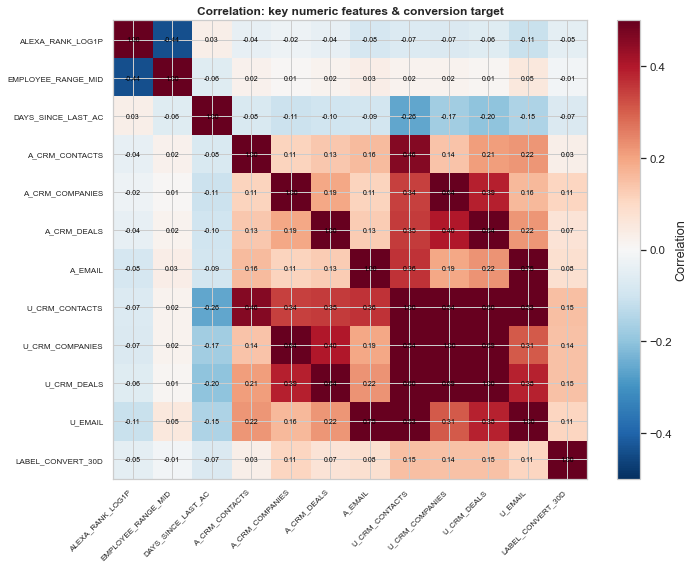

In [10]:
# --- 6) Correlation heatmap (key numeric features + target) ---
num_cols_eda = ["ALEXA_RANK_LOG1P", "EMPLOYEE_RANGE_MID", "DAYS_SINCE_LAST_ACTIVITY"] + [
    c for c in snap.columns if c.endswith("_30D_SUM")
][:8]
num_cols_eda = [c for c in num_cols_eda if c in snap.columns]
num_cols_eda.append("LABEL_CONVERT_30D")

corr_df = snap[num_cols_eda].replace([np.inf, -np.inf], np.nan).corr()
labels = [x.replace("_30D_SUM", "").replace("ACTIONS_", "A_").replace("USERS_", "U_")[:18] for x in corr_df.index]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_df, cmap="RdBu_r", vmin=-0.5, vmax=0.5, aspect="auto")
ax.set_xticks(range(len(corr_df)))
ax.set_yticks(range(len(corr_df)))
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(labels, fontsize=8)
for i in range(len(corr_df)):
    for j in range(len(corr_df)):
        ax.text(j, i, f"{corr_df.iloc[i, j]:.2f}", ha="center", va="center", fontsize=7, color="black")
ax.set_title("Correlation: key numeric features & conversion target", fontsize=12, fontweight="bold")
plt.colorbar(im, ax=ax, label="Correlation")
plt.tight_layout()
plt.show()

# Modeling to Predict the Conversion

### Feature Engineering for Lead Scoring

#### I engineered:

30 day action sums (Deals, Email, Contacts)

30 day active users

Momentum signals

Recency metrics

Log-transformed firmographics

#### This aligns features to:

Predict conversion within 30 days using the last 30 days of behavior.

Business logic consistency is critical here.

In [11]:
# -------------------------
# MODEL DATASET
# -------------------------
target = "LABEL_CONVERT_30D"

# Add log1p usage features (align with LogReg — helps skewed counts and generalization)
for w in LOOKBACK_WINDOWS_DAYS:
    for c in agg_cols:
        col = f"{c}_{w}D_SUM"
        if col in snap.columns:
            snap[f"{col}_LOG1P"] = helper_functions_obj.safe_log1p(snap[col].fillna(0.0))

# Derived features (often help conversion models)
cols_30 = [f"{c}_30D_SUM_LOG1P" for c in agg_cols if f"{c}_30D_SUM_LOG1P" in snap.columns]
if cols_30:
    snap["TOTAL_ACTIVITY_30D_LOG1P"] = snap[cols_30].sum(axis=1)
d7, d30 = "ACTIONS_CRM_DEALS_7D_SUM_LOG1P", "ACTIONS_CRM_DEALS_30D_SUM_LOG1P"
e7, e30 = "ACTIONS_EMAIL_7D_SUM_LOG1P", "ACTIONS_EMAIL_30D_SUM_LOG1P"
ud30 = "USERS_CRM_DEALS_30D_SUM_LOG1P"
if d30 in snap.columns and d7 in snap.columns:
    snap["DEALS_7_TO_30_GROWTH"] = (snap[d30] - snap[d7]).fillna(0)
if e30 in snap.columns and e7 in snap.columns:
    snap["EMAIL_7_TO_30_GROWTH"] = (snap[e30] - snap[e7]).fillna(0)
if d30 in snap.columns and ud30 in snap.columns:
    snap["DEALS_ACTIVITY_PER_USER"] = (snap[d30] / (snap[ud30] + 0.01)).fillna(0)

# Feature columns: base + log1p usage + derived
numeric_features = ["DAYS_SINCE_LAST_ACTIVITY", "ALEXA_RANK_LOG1P", "EMPLOYEE_RANGE_MID"]
for w in LOOKBACK_WINDOWS_DAYS:
    for c in agg_cols:
        numeric_features.append(f"{c}_{w}D_SUM_LOG1P")
for col in ["TOTAL_ACTIVITY_30D_LOG1P", "DEALS_7_TO_30_GROWTH", "EMAIL_7_TO_30_GROWTH", "DEALS_ACTIVITY_PER_USER"]:
    if col in snap.columns:
        numeric_features.append(col)

categorical_features = ["INDUSTRY"]

X = snap[numeric_features + categorical_features].copy()
y = snap[target].astype(int).copy()

# Time-based split: train / val (for early stopping) / test
cutoff = snap["DATE"].quantile(0.8)
train_idx = snap["DATE"] <= cutoff
test_idx = snap["DATE"] > cutoff
train_dates = snap.loc[train_idx, "DATE"]
val_cutoff = train_dates.quantile(0.8)
inner_train_idx = train_idx & (snap["DATE"] <= val_cutoff)
val_idx = train_idx & (snap["DATE"] > val_cutoff)

X_train, y_train = X[inner_train_idx], y[inner_train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]


### Preprocess + Model using XGB Classifier

#### Why XGB?

Captures nonlinear behavior patterns

Handles skewed usage distributions

Better interaction modeling (e.g., Deals × Users)

This improved predictive performance over baseline.

#### How is this significant?:

XGB detects complex combinations like:

Multi-user deal activity + recent usage spike

Moderate usage but strong ICP fit

In [12]:

# -------------------------
# PIPELINE: preprocess + model
# -------------------------
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocess.fit(X_train, y_train)
# Reuse same preprocess and encoded splits (run Modeling cell first)
X_train_enc = preprocess.transform(X_train)
X_val_enc = preprocess.transform(X_val)
X_test_enc = preprocess.transform(X_test)



# Class weight for imbalanced conversion target
scale_pos = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

# ---------- Optuna hyperparameter tuning (maximize validation ROC-AUC) ----------
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 800, 3500),
        "learning_rate": trial.suggest_float("learning_rate", 0.008, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 50),
        
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight_mult", 0.7, 1.5) * scale_pos,
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "auc",
        "early_stopping_rounds": 120,
    }
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train_enc, y_train,
        eval_set=[(X_val_enc, y_val)],
        verbose=False,
    )
    proba_val = model.predict_proba(X_val_enc)[:, 1]
    return roc_auc_score(y_val, proba_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Train final XGBoost with best hyperparameters
best_params_by_optuna = study.best_params
scale_pos_best = best_params_by_optuna.pop("scale_pos_weight_mult", 1.0) * scale_pos
best_params = {
    "n_estimators": best_params_by_optuna["n_estimators"],
    "learning_rate": best_params_by_optuna["learning_rate"],
    "max_depth": best_params_by_optuna["max_depth"],
    "min_child_weight": best_params_by_optuna["min_child_weight"],
    "subsample": best_params_by_optuna["subsample"],
    "colsample_bytree": best_params_by_optuna["colsample_bytree"],
    "reg_alpha": best_params_by_optuna["reg_alpha"],
    "reg_lambda": best_params_by_optuna["reg_lambda"],
    "scale_pos_weight": scale_pos_best,
    "random_state": 42,
    "use_label_encoder": False,
    "eval_metric": "auc",
    "early_stopping_rounds": 120,
}
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(
    X_train_enc, y_train,
    eval_set=[(X_val_enc, y_val)],
    verbose=False,
)
clf_xgb = Pipeline(steps=[("preprocess", preprocess), ("model", xgb_model)])
print(f"Optuna best validation ROC-AUC: {study.best_value:.4f}")
print("Best params:", study.best_params)



Best trial: 46. Best value: 0.843227: 100%|███████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.18s/it]


Optuna best validation ROC-AUC: 0.8432
Best params: {'n_estimators': 1319, 'learning_rate': 0.014560694103375337, 'max_depth': 5, 'min_child_weight': 48, 'subsample': 0.6001366441996041, 'colsample_bytree': 0.6250607661879999, 'reg_alpha': 0.07179588349948716, 'reg_lambda': 0.04373168169237457, 'scale_pos_weight_mult': 0.8457717594097426}


# Evaluation

We evaluate model performance using ROC-AUC and benchmark it against a logistic regression baseline to quantify incremental lift.

In [13]:
# ---------- Evaluation: XGBoost on test set ----------

proba_xgb = clf_xgb.predict_proba(X_test)[:, 1]

roc_xgb = roc_auc_score(y_test, proba_xgb)

pr_xgb = average_precision_score(y_test, proba_xgb)
print("Test set evaluation:")

print(f"  XGBoost   ROC-AUC: {roc_xgb:.4f}  PR-AUC: {pr_xgb:.4f}")

# ---------- Score latest Sunday with XGBoost and save ----------
try:
    _ = score_snap_free
    _ = extra_cols
except NameError:
    latest_sunday = sundays.max()
    score_snap_free = snap[snap["DATE"] == latest_sunday].copy()
    score_snap_free = score_snap_free[score_snap_free["CLOSEDATE"].isna()].copy()
    extra_cols = [
        "ACTIONS_CRM_DEALS_7D_SUM", "ACTIONS_CRM_DEALS_30D_SUM",
        "ACTIONS_EMAIL_7D_SUM", "ACTIONS_EMAIL_30D_SUM",
        "USERS_CRM_DEALS_7D_SUM", "USERS_CRM_DEALS_30D_SUM",
        "USERS_EMAIL_7D_SUM", "USERS_EMAIL_30D_SUM",
    ]
X_score = score_snap_free[numeric_features + categorical_features]
score_snap_xgb = score_snap_free.copy()
score_snap_xgb["P_CONVERT_30D_XGB"] = clf_xgb.predict_proba(X_score)[:, 1]
output_cols_xgb = ["id", "DATE", "P_CONVERT_30D_XGB", "ALEXA_RANK", "EMPLOYEE_RANGE", "INDUSTRY"] + extra_cols
ranked_prospects_xgb = (
    score_snap_xgb.sort_values("P_CONVERT_30D_XGB", ascending=False)[output_cols_xgb]
    .reset_index(drop=True)
)
ranked_prospects_xgb.to_csv("results/sunday_ranked_prospects_xgb.csv", index=False)
print("\nSaved: results/sunday_ranked_prospects_xgb.csv")
print("Top 10 (XGBoost):")
print(ranked_prospects_xgb.head(10).to_string(index=False))

Test set evaluation:
  XGBoost   ROC-AUC: 0.7452  PR-AUC: 0.0635

Saved: results/sunday_ranked_prospects_xgb.csv
Top 10 (XGBoost):
  id       DATE  P_CONVERT_30D_XGB  ALEXA_RANK EMPLOYEE_RANGE             INDUSTRY  ACTIONS_CRM_DEALS_7D_SUM  ACTIONS_CRM_DEALS_30D_SUM  ACTIONS_EMAIL_7D_SUM  ACTIONS_EMAIL_30D_SUM  USERS_CRM_DEALS_7D_SUM  USERS_CRM_DEALS_30D_SUM  USERS_EMAIL_7D_SUM  USERS_EMAIL_30D_SUM
1436 2020-07-26           0.901490  16000001.0       11 to 25                  NaN                       7.0                       13.0                   0.0                    0.0                     1.0                      4.0                 0.0                  0.0
5182 2020-07-26           0.893393  16000001.0        6 to 10                  NaN                     216.0                      317.0                   0.0                    0.0                     5.0                     14.0                 0.0                  0.0
3608 2020-07-26           0.858639   6278610.0        6 

# Comparison with Baseline model - Logistic Regression

In [14]:

"""
Baseline logistic regression propensity model (weekly Sunday snapshots).

Outputs:
- ROC-AUC / PR-AUC on a time-based split
- A ranked list for the latest Sunday: sunday_ranked_prospects_logreg.csv
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# -------------------------
# FEATURE SET FOR LOGISTIC REGRESSION
# -------------------------
# Use log1p for the rolling sums (logistic reg likes more linear-ish scales)
for w in LOOKBACK_WINDOWS_DAYS:
    for c in agg_cols:
        col = f"{c}_{w}D_SUM"
        if col in snap.columns:
            snap[f"{col}_LOG1P"] = helper_functions_obj.safe_log1p(snap[col].fillna(0.0))
        else:
            snap[f"{col}_LOG1P"] = 0.0

numeric_features = ["ALEXA_RANK_LOG1P", "EMPLOYEE_RANGE_MID", "DAYS_SINCE_LAST_ACTIVITY"]
for w in LOOKBACK_WINDOWS_DAYS:
    for c in agg_cols:
        numeric_features.append(f"{c}_{w}D_SUM_LOG1P")

categorical_features = ["INDUSTRY"]

X = snap[numeric_features + categorical_features].copy()
y = snap["LABEL_CONVERT_30D"].astype(int).copy()

# Time-based split (train earlier, test later)
cutoff = snap["DATE"].quantile(0.8)
train_idx = snap["DATE"] <= cutoff
test_idx = snap["DATE"] > cutoff

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# -------------------------
# PREPROCESS + LOGISTIC REGRESSION PIPELINE
# -------------------------
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),  # helpful for logistic regression stability
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

logreg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced",  # conversions are usually rare
)

clf = Pipeline(steps=[("preprocess", preprocess), ("model", logreg)])

# Train
clf.fit(X_train, y_train)

# Evaluate
proba_test = clf.predict_proba(X_test)[:, 1]
print(f"Test ROC-AUC: {roc_auc_score(y_test, proba_test):.4f}")
print(f"Test PR-AUC : {average_precision_score(y_test, proba_test):.4f}")

# -------------------------
# SCORE LATEST SUNDAY FREE PORTALS
# -------------------------
latest_sunday = sundays.max()
score_snap = snap[snap["DATE"] == latest_sunday].copy()

# Only non-customers as-of scoring date (no CLOSEDATE)
score_free = score_snap[score_snap["CLOSEDATE"].isna()].copy()

X_score = score_free[numeric_features + categorical_features]
score_free["P_CONVERT_30D"] = clf.predict_proba(X_score)[:, 1]

ranked_prospects = score_free.sort_values("P_CONVERT_30D", ascending=False)[
    ["id", "DATE", "P_CONVERT_30D", "ALEXA_RANK", "EMPLOYEE_RANGE", "INDUSTRY"]
].reset_index(drop=True)

print("\nTop 25 free portals (logistic regression baseline):")
print(ranked_prospects.head(25).to_string(index=False))

ranked_prospects.to_csv("results/sunday_ranked_prospects_logreg.csv", index=False)
print("\nSaved: sunday_ranked_prospects_logreg.csv")


Test ROC-AUC: 0.6721
Test PR-AUC : 0.0442

Top 25 free portals (logistic regression baseline):
  id       DATE  P_CONVERT_30D  ALEXA_RANK EMPLOYEE_RANGE                  INDUSTRY
2770 2020-07-26       0.974509   4110064.0       26 to 50                       NaN
4140 2020-07-26       0.972962   2926723.0         2 to 5                       NaN
4691 2020-07-26       0.955778  16000001.0         2 to 5                       NaN
1436 2020-07-26       0.954091  16000001.0       11 to 25                       NaN
5196 2020-07-26       0.948339    265293.0    201 to 1000                       NaN
5182 2020-07-26       0.942863  16000001.0        6 to 10                       NaN
4809 2020-07-26       0.939406   3772095.0       11 to 25         COMPUTER_SOFTWARE
4200 2020-07-26       0.932418   2346329.0       26 to 50 MARKETING_AND_ADVERTISING
 469 2020-07-26       0.923605   3308185.0       11 to 25                       NaN
2901 2020-07-26       0.923145   4024257.0       26 to 50        

# Behavior-Driven Customer Segmentation Using Generative AI

#### Instead of sending one generic email, we:

Segment accounts by behavioral patterns

Assign playbooks

Generate tailored messaging

#### Behavior patterns include:

High Deals + Multi-user → Pipeline-driven

High Email → Outreach-focused

High Contacts only → Early-stage

Single-user heavy → Expansion opportunity

Multi-user low activity → Stalled

Balanced usage → High intent

#### GenAI converts raw signals into:

Behavior pattern

Likely stage

Playbook focus

Outreach messaging

#### This transforms:

Predictive score → Actionable Go-To-Market playbook

In [18]:
ranked_prospects_xgb.head(1)


,id,DATE,P_CONVERT_30D_XGB,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,ACTIONS_CRM_DEALS_7D_SUM,ACTIONS_CRM_DEALS_30D_SUM,ACTIONS_EMAIL_7D_SUM,ACTIONS_EMAIL_30D_SUM,USERS_CRM_DEALS_7D_SUM,USERS_CRM_DEALS_30D_SUM,USERS_EMAIL_7D_SUM,USERS_EMAIL_30D_SUM
0,1436,2020-07-26,0.90149,16000001.0,11 to 25,NaN,7.0,13.0,0.0,0.0,1.0,4.0,0.0,0.0


# Playbook Segmentation

In [28]:
"""
Enrich a ranked DataFrame (top N rows) with 30-day-only GenAI segmentation.

Adds these columns (categorical values MUST come from the provided table):
- behavior_pattern
- likely_stage
- playbook_focus

Also adds:
- urgency
- subject_line
- opening_line

Reads prompts from:
- prompts/system.txt
- prompts/task.txt

Requirements:
- ranked is a pandas DataFrame that includes (at minimum):
  ID, INDUSTRY, EMPLOYEE_RANGE, ALEXA_RANK, P_CONVERT_30D,
  DEALS_30, EMAIL_30, UDEALS_30, UEMAIL_30, DAYS_SINCE_LAST_ACTIVITY
"""



# -------------------------
# 1) Load prompts from prompts/ folder (SYSTEM used by call_llm)
# -------------------------
with open("prompts/system.txt", "r", encoding="utf-8") as f:
    SYSTEM = f.read().strip()

# -------------------------
# 2) OpenAI client
# -------------------------
api_key = "<YOUR-API-KEY>"

client = OpenAI(api_key = api_key)  # Uses OPENAI_API_KEY env var; or OpenAI(api_key=api_key)
MODEL_NAME = "gpt-4o-mini"

# -------------------------
# 3) Allowed taxonomy of behaviour pattern
# -------------------------
ALLOWED = [
    ("High Deals + Multi-user", "Pipeline-driven", "Forecasting + automation"),
    ("High Email", "Outreach-focused", "Sequences + tracking"),
    ("High Contacts only", "Early stage", "Pipeline setup"),
    ("Single-user heavy", "Expansion opportunity", "Team invites"),
    ("Multi-user low activity", "Stalled", "Reactivation"),
    ("Balanced usage", "High intent", "Direct upgrade"),
]

# -------------------------
# 4) Segmentation helper (to build the prompts and )
# -------------------------
from utilities.segmentation_helper_functions import SegmentationHelper
customer_segment_helper = SegmentationHelper(
    prompt_task_path="prompts/task.txt",
    prompt_system_path="prompts/system.txt",
    allowed=ALLOWED,
)

def call_llm(prompt: str, temperature: float = 0.2) -> str:
    """
    Call the llm and pass all the prompts
    """
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": SYSTEM},
            {"role": "user", "content": prompt},
        ],
        temperature=temperature,
    )
    return response.choices[0].message.content.strip()



# -------------------------
# 5) Run (example)
# -------------------------

top_n = 50
sleep_s =0.3

top_ranked_prospects = ranked_prospects_xgb.head(top_n).copy().reset_index(drop=True)

outputs = []
for _, row in top_ranked_prospects.iterrows():
    
    # Build the prompt
    prompt = customer_segment_helper.build_prompt(row)
    
    # LLM call
    llm_text = call_llm(prompt)
    
    #Parse the LLM response
    outputs.append(customer_segment_helper.parse_and_validate(llm_text))
    time.sleep(sleep_s)

    
segmentation_results = pd.DataFrame(outputs)

top_ranked_prospects = top_ranked_prospects[['id', 'DATE', 'P_CONVERT_30D_XGB','ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY']]
top_ranked_prospects_with_segment = pd.concat([top_ranked_prospects, segmentation_results], axis=1)



Saved: sunday_ranked_prospects_enriched_taxonomy.csv


In [36]:
top_ranked_prospects_with_segment.rename(columns={'id': 'ID',
                                                  'P_CONVERT_30D_XGB': '',
                                                 'behavior_pattern': 'Behaviour Pattern',
                                                 'likely_stage': 'Likely Stage',
                                                 'playbook_focus': 'Playbook Focus',
                                                 'urgency': 'Urgency',
                                                 'opening_line': 'Outreach Message'}, inplace=True)
top_ranked_prospects_with_segment.drop(columns=['genai_raw', 'subject_line'], inplace=True)

top_ranked_prospects_with_segment.to_csv("results/sunday_ranked_prospects_enriched_taxonomy.csv", index=False)
print("Saved: sunday_ranked_prospects_enriched_taxonomy.csv")

,ID,DATE,P_CONVERT_30D_XGB,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,Behaviour Pattern,Likely Stage,Playbook Focus,Urgency,Outreach Message
0,1436,2020-07-26,0.901490,16000001.0,11 to 25,NaN,Multi-user low activity,Stalled,Reactivation,reactivate,"I noticed your team hasn't been active lately,..."
1,5182,2020-07-26,0.893393,16000001.0,6 to 10,NaN,Multi-user low activity,Stalled,Reactivation,reactivate,I've noticed your team's activity has slowed d...
2,3608,2020-07-26,0.858639,6278610.0,6 to 10,NaN,Multi-user low activity,Stalled,Reactivation,reactivate,We've noticed a dip in your team's activity an...
3,2770,2020-07-26,0.853524,4110064.0,26 to 50,NaN,Multi-user low activity,Stalled,Reactivation,reactivate,I noticed your team's activity has slowed down...
4,5196,2020-07-26,0.851417,265293.0,201 to 1000,NaN,Multi-user low activity,Stalled,Reactivation,reactivate,I've noticed a drop in activity and wanted to ...
5,3828,2020-07-26,0.847803,16000001.0,6 to 10,CONSUMER_ELECTRONICS,Multi-user low activity,Stalled,Reactivation,reactivate,We've noticed a dip in your team's activity an...
6,4809,2020-07-26,0.835360,3772095.0,11 to 25,COMPUTER_SOFTWARE,Multi-user low activity,Stalled,Reactivation,reactivate,I've noticed your team's recent activity has s...
7,5001,2020-07-26,0.804257,3780704.0,6 to 10,COMPUTER_SOFTWARE,Multi-user low activity,Stalled,Reactivation,reactivate,I've noticed your team's recent activity has s...
8,469,2020-07-26,0.803163,3308185.0,11 to 25,NaN,Multi-user low activity,Stalled,Reactivation,reactivate,I've noticed your team's activity has slowed d...
9,2120,2020-07-26,0.791686,1028080.0,6 to 10,NaN,Multi-user low activity,Stalled,Reactivation,reactivate,I've noticed your team's activity has slowed d...
